# STEP 01: ETL, Version 002

In this notebook, the data extraction for the weather data is covered. There are three data sources that are processed:

**1. Weather: Information on temperature, cloud coverage, precipitation, etc at the location using the DarkSkyAPI**<br>
*2. Sun position: Information on the position of the sun in the sky at the location using pysolar.solar*<br>
*3. Solar panel production: Information on the amount of energy produced by the solar panels at the location*<br>

# Weather Data

The first step is to get the weather data for the location where the solar panel is located. The location coordinates can be taken for example from Google Maps (latitude, longitude). In this case, the location information is stored in a file along with the secret for the API of DarkSky (https://darksky.net/dev). Signup there is free, as long as one stays below 1000 API calls per 24 hours. 

The way this works is that the DarkSky API is called and returns hourly, historical data for each day that is requested. The response from the API (json files) will be stored locally and then be processed into one big csv file with all the data from the API. For the Time Series Analysis, not all data is relevant and it will be cleaned later on.

In [18]:
import datetime
from time import mktime
import pandas as pd
import numpy as np
import requests
import re
import json
import os
import plotly
plotly.offline.init_notebook_mode(connected=True)


from dateutil import tz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## 1. Get the location where the solar panel is, get DarkSkyAPI

In [2]:
location = [0,0]
DarkSkySecret = 'none'
credentials = './.credentials.pw'

ii = 0
with open(credentials, 'r') as file:
    for line in file:
        ii = ii + 1
        line = line.rstrip().split(',')
        if ii == 4:
#             print(line)
            location[0] = line[1]
            location[1] = line[2] 
        if ii == 3:        
#         if ii == 2: # other key
            DarkSkySecret = line[1]
    file.close()

## 2. Testing the API: Pick a date in the past and get hourly data from API

Documentation of the DarkSkyAPI is under: https://darksky.net/dev/docs


Note that the API returns the time in the **local** time zone

In [3]:
# create some date
mydate = '1527559200'
# date = datetime.datetime.strptime(mydate, '%Y-%m-%d')

# option list for API
option_list = "exclude=currently,minutely,alerts&units=si"


# call API
latitude = str(location[0])
longitude = str(location[1])

response = requests.get("https://api.darksky.net/forecast/"+DarkSkySecret+"/"+latitude+","+longitude+","+mydate+"?"+option_list)
json_res = response.json()
mylist = json_res['hourly']['data']
print(f'For this day there are {len(mylist)} records from the API')
mylist[4]

For this day there are 24 records from the API


{'time': 1527559200,
 'summary': 'Overcast',
 'icon': 'cloudy',
 'precipType': 'rain',
 'temperature': 19.07,
 'apparentTemperature': 19.07,
 'dewPoint': 15,
 'humidity': 0.77,
 'windSpeed': 3.6,
 'windBearing': 230,
 'cloudCover': 1,
 'uvIndex': 0,
 'visibility': 10.003}

## 3. Plots

Check first that the local time is correct

In [12]:
mylist = json_res['hourly']['data']

# .strftime('%Y-%m-%d %H:%M:%S')
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
times = []
for t in mylist:
    utc_time = datetime.datetime.utcfromtimestamp(t['time'])
    
    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc_time = utc_time.replace(tzinfo=from_zone)

    # Convert time zone
    localtime = utc_time.astimezone(to_zone)
    times.append(localtime.hour)
    print(localtime)

2018-05-21 00:00:00+02:00
2018-05-21 01:00:00+02:00
2018-05-21 02:00:00+02:00
2018-05-21 03:00:00+02:00
2018-05-21 04:00:00+02:00
2018-05-21 05:00:00+02:00
2018-05-21 06:00:00+02:00
2018-05-21 07:00:00+02:00
2018-05-21 08:00:00+02:00
2018-05-21 09:00:00+02:00
2018-05-21 10:00:00+02:00
2018-05-21 11:00:00+02:00
2018-05-21 12:00:00+02:00
2018-05-21 13:00:00+02:00
2018-05-21 14:00:00+02:00
2018-05-21 15:00:00+02:00
2018-05-21 16:00:00+02:00
2018-05-21 17:00:00+02:00
2018-05-21 18:00:00+02:00
2018-05-21 19:00:00+02:00
2018-05-21 20:00:00+02:00
2018-05-21 21:00:00+02:00
2018-05-21 22:00:00+02:00
2018-05-21 23:00:00+02:00


In [13]:
temperatures = []
for t in mylist:
#     print(t['temperature'])
    temperatures.append(t['temperature'])

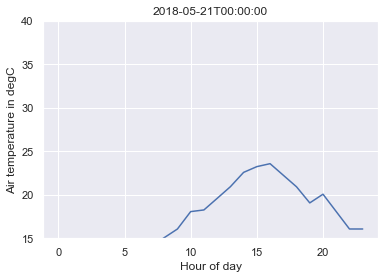

In [14]:
plt.plot(times, temperatures)
plt.xlabel('Hour of day')
plt.ylabel('Air temperature in degC')
plt.title(mydate)
plt.ylim(15,40)
plt.show()

## 4. Make a function

- Inputs: 
    - location: location where the weather should be requested. Format: ['longitude', 'latitude]
    - day: day for which hourly data should be requested. Format: '2019-06-26T12:00:00'
- Output:
    - json object from the API

In [36]:
import datetime
import pandas as pd
import requests
import re
import json

def getWeatherData(location, UNIX_time):
    # option list for API
    option_list = "exclude=currently,minutely,alerts&units=si"

    # call API
    latitude = location[0]
    longitude = location[1]

    response = requests.get("https://api.darksky.net/forecast/"+DarkSkySecret+"/"+latitude+","+longitude+","+str(UNIX_time)+"?"+option_list)
    json_res = response.json()
    
    return json_res

## 5. Get the data for a certain date range

Repeatedly calls to the getWeatherData-function will get the weather data for the location for the respective day hourly. The reponse json object will be stored in a folder for further processing.

In [39]:
# where to store the API data
save_path = "./data/DarkSkyAPI/"

# date range
startDate = '2017-10-01'
endDate = '2019-06-29'

# convert to a time delta
d_from_date = datetime.datetime.strptime(startDate, '%Y-%m-%d')
d_to_date = datetime.datetime.strptime(endDate , '%Y-%m-%d')
delta = d_to_date - d_from_date

# for every day in the date range, get the data
for i in range(delta.days+1):
#     new_date = (d_from_date + datetime.timedelta(days=i)).strftime('%Y-%m-%d')
    new_date = (d_from_date + datetime.timedelta(days=i)) + pd.DateOffset(hours=15)

    # convert to datetime
    new_date = new_date.to_pydatetime()  

    # convert the date to UNIX time
    UNIX_time = int(mktime(new_date.timetuple()))
    str_date = new_date.strftime('%Y-%m-%d')

    # call API
    data = getWeatherData(location, UNIX_time)
    
    # write to file
    with open(f'{save_path}/{str_date}.json', 'w') as outfile:  
        json.dump(data, outfile)
        outfile.close()

## 6. Clean up the weather data

Now that the data for each day is stored as a json object, it can be cleaned up. First, lets explore the dataset structure.

In [42]:
path_to_jsons = './data/DarkSkyAPI/'

# list all the json objects in the path
jsons = os.listdir(path_to_jsons)
# make sure that there are only json files
jsons = [j for j in jsons if j.endswith('.json')]

# load one file to examine
with open(f'{path_to_jsons}{jsons[0]}') as f:
    d = json.load(f)
    f.close()
    
    
d.keys()

dict_keys(['latitude', 'longitude', 'timezone', 'hourly', 'daily', 'flags', 'offset'])

It seems that the jsons contain as a dictionary the entries 'latitude', 'longitude', 'timezone', 'hourly', 'daily', 'flags', 'offset'. Lets check what those contain.

In [43]:
for key in d.keys():
    print(f'Key {key} contains: {d[key]}')

Key latitude contains: 47.964718
Key longitude contains: 7.955852
Key timezone contains: Europe/Berlin
Key hourly contains: {'summary': 'Foggy starting in the morning.', 'icon': 'fog', 'data': [{'time': 1548025200, 'summary': 'Partly Cloudy', 'icon': 'partly-cloudy-night', 'precipIntensity': 0.01, 'precipProbability': 0.01, 'precipType': 'snow', 'precipAccumulation': 0.06, 'temperature': -1.59, 'apparentTemperature': -1.59, 'dewPoint': -5.05, 'humidity': 0.77, 'pressure': 1019.68, 'windSpeed': 1.09, 'windGust': 1.44, 'windBearing': 81, 'cloudCover': 0.48, 'uvIndex': 0, 'visibility': 16.093, 'ozone': 343}, {'time': 1548028800, 'summary': 'Partly Cloudy', 'icon': 'partly-cloudy-night', 'precipIntensity': 0.01, 'precipProbability': 0.01, 'precipType': 'snow', 'precipAccumulation': 0.08, 'temperature': -2.33, 'apparentTemperature': -4.57, 'dewPoint': -6.1, 'humidity': 0.75, 'pressure': 1020.17, 'windSpeed': 1.59, 'windGust': 1.84, 'windBearing': 38, 'cloudCover': 0.47, 'uvIndex': 0, 'visib

The data is in the key 'hourly'. The rest is not useful information, but can be used to cross check. For further info, see the DarkSky API. The data in the 'hourly' key is stored in the 'data'-key and as a separate dictionary for each timestamp stored in a list, found via `d['hourly']['data']`. The timestamps are encoded in UNIX time. The data contained is explained in detail here: https://darksky.net/dev/docs#data-point-object




In [44]:
d['hourly']['data'][1]

{'time': 1548028800,
 'summary': 'Partly Cloudy',
 'icon': 'partly-cloudy-night',
 'precipIntensity': 0.01,
 'precipProbability': 0.01,
 'precipType': 'snow',
 'precipAccumulation': 0.08,
 'temperature': -2.33,
 'apparentTemperature': -4.57,
 'dewPoint': -6.1,
 'humidity': 0.75,
 'pressure': 1020.17,
 'windSpeed': 1.59,
 'windGust': 1.84,
 'windBearing': 38,
 'cloudCover': 0.47,
 'uvIndex': 0,
 'visibility': 16.093,
 'ozone': 342.9}

The approach now is clear: First the jsons will be loaded, the data for each timestamp extracted and all stored in a dataframe. Each row of the dataframe will correspond to one timestamp.

In [45]:
# ii = 0
df = pd.DataFrame()

# loop over the json files
for item in jsons:
# ii can be used to load just a few, uncomment the lines    
#     ii = ii + 1
#     if ii < 10:

# open the json file and load it
    with open(f'{path_to_jsons}{item}') as file:
        d = json.load(file)
        # loop over the hourly data, append it to the dataframe
        for row in d['hourly']['data']:
            s = pd.Series(row)
            df = df.append(s,ignore_index=True)

    file.close()

print(df.info())
print(df.describe())
print(df.head())

df.to_csv(f'{path_to_jsons}/darkSkyData.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14811 entries, 0 to 14810
Data columns (total 19 columns):
apparentTemperature    14811 non-null float64
cloudCover             11325 non-null float64
dewPoint               14811 non-null float64
humidity               14811 non-null float64
icon                   14811 non-null object
ozone                  8766 non-null float64
precipAccumulation     424 non-null float64
precipIntensity        14320 non-null float64
precipProbability      14320 non-null float64
precipType             6097 non-null object
pressure               14318 non-null float64
summary                14811 non-null object
temperature            14811 non-null float64
time                   14811 non-null float64
uvIndex                13347 non-null float64
visibility             13102 non-null float64
windBearing            14696 non-null float64
windGust               14292 non-null float64
windSpeed              14739 non-null float64
dtypes: float64(16), obj

Each row in the dataframe corresponds to a datapoint at one hour. As there are 24 hours in a day and each json file contains the data for one day, the number of rows divided by 24 must be equal to the number of unique timestamps in the series.

We see this is not the case, so we have to investigate what is going on!

In [ ]:
assert (len(df['time'].unique())/24) == len(jsons)

Let us now convert the timestamps from UNIX time into the local time, which is in this case for the timezone that is +2 hours from the UTC.

In [9]:
def convertUNIXtoUTC(utc_time):
    """
    Takes a time in UTC time and converts it into the local time.
    """
    utc_time = datetime.datetime.utcfromtimestamp(utc_time)
    
    return utc_time

In [47]:
# convert UNIX to UTC time and add 2 hours to get to local time
df['date'] = df['time'].apply(lambda x: convertUNIXtoUTC(x)) + pd.DateOffset(hours=2)

# sort by the time
df_cleaned = df.sort_values(by=['time'], ascending=True)

# make the date the index
df_cleaned.set_index('date', inplace=True)

# save as csv
df_cleaned.to_csv(f'{path_to_jsons}/darkSkyData_cleaned.csv')

df_cleaned.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipAccumulation,precipIntensity,precipProbability,precipType,pressure,summary,temperature,time,uvIndex,visibility,windBearing,windGust,windSpeed
date,,,,,,,,,,,,,,,,,,,
2017-10-01 00:00:00,10.99,0.75,10.09,0.94,rain,NaN,NaN,0.07,0.46,rain,1021.82,Possible Drizzle,10.99,1.506809e+09,0.0,9.988,268.0,1.03,0.65
2017-10-01 01:00:00,11.07,NaN,10.02,0.93,clear-night,NaN,NaN,0.02,0.16,rain,1021.85,Clear,11.07,1.506812e+09,0.0,9.988,258.0,0.61,0.42
2017-10-01 02:00:00,10.87,NaN,9.64,0.92,clear-night,NaN,NaN,0.00,0.00,NaN,1022.33,Clear,10.87,1.506816e+09,0.0,9.988,233.0,0.55,0.13
2017-10-01 03:00:00,10.77,NaN,9.55,0.92,clear-night,NaN,NaN,0.00,0.00,NaN,1022.51,Clear,10.77,1.506820e+09,0.0,9.988,194.0,0.36,0.13
2017-10-01 04:00:00,10.47,NaN,9.05,0.91,clear-night,NaN,NaN,0.00,0.00,NaN,1022.64,Clear,10.47,1.506823e+09,0.0,9.988,258.0,0.44,0.29


In [13]:
g_by_day = df_cleaned.groupby(df_cleaned.index.date)['temperature'].count()
# print(len(g_by_day[g_by_day !=24]), len(jsons))
s_missing = g_by_day[g_by_day !=24]
s_missing

2018-05-19    19
2018-05-20    10
2018-05-21     8
2018-05-22    13
2018-05-23    14
2018-05-24    16
2018-05-25    15
2018-05-26    10
2018-05-27    10
2018-05-28    16
2018-05-29    13
2018-05-30    14
2018-05-31    10
2018-06-01    13
2018-06-02    11
2018-06-03    12
2018-06-04    13
2018-06-05    13
2018-06-06    15
2018-06-07    13
2018-06-08    14
2018-06-09    10
2018-06-10     8
2018-06-11    14
2018-06-12    15
2018-06-13    13
2018-06-14    13
2018-06-15    13
2018-06-16     4
2018-06-17    10
2018-06-18    13
2018-06-19    13
2018-06-20    13
2018-06-21    12
2018-06-22    13
2018-06-23    12
2018-06-24    10
2018-06-25    16
2018-06-26    15
2018-06-27    13
2018-06-28    13
2018-06-29    16
Name: temperature, dtype: int64

It seems that for 42 days out of 637, which is around 7%, we do not have 24 datapoints. That's not great! Repeated checks with the API show that for some days, not all data is available. The cases where the API reports more than 25 entries correspond to overlapping timestamps, which is strange, but it seems in the two cases 2018-10-28 and 2017-10-29, the values match for the corresponding next day, since they are not included in that API call.

What we could do it obtain data from a different API at those dates in question or infer the values from the adjacent days. Right now, we will leave it like this but keep these missing data in mind.

# Load the cleaned data

In [88]:
import datetime
from time import mktime
import pandas as pd
import numpy as np
import requests
import re
import json
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

path_to_jsons = './data/DarkSkyAPI/'
data = pd.read_csv(f'{path_to_jsons}/darkSkyData_cleaned.csv', index_col = 0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')
# drop unwanted columns
data = data.drop(['summary', 'time', 'windBearing', 'dewPoint', 'ozone', 'icon', 'windGust'],axis='columns')
print(data.head())
print(data.info())
print(data.shape)

                     apparentTemperature  cloudCover  humidity  \
date                                                             
2017-10-01 00:00:00                10.99        0.75      0.94   
2017-10-01 01:00:00                11.07         NaN      0.93   
2017-10-01 02:00:00                10.87         NaN      0.92   
2017-10-01 03:00:00                10.77         NaN      0.92   
2017-10-01 04:00:00                10.47         NaN      0.91   

                     precipAccumulation  precipIntensity  precipProbability  \
date                                                                          
2017-10-01 00:00:00                 NaN             0.07               0.46   
2017-10-01 01:00:00                 NaN             0.02               0.16   
2017-10-01 02:00:00                 NaN             0.00               0.00   
2017-10-01 03:00:00                 NaN             0.00               0.00   
2017-10-01 04:00:00                 NaN             0.00       

In [89]:
g_by_day = data.groupby(data.index.date)['temperature'].count()
s_missing = g_by_day[g_by_day !=24]
print(g_by_day[g_by_day ==24].sum())
s_missing

14280


2018-05-19    19
2018-05-20    10
2018-05-21     8
2018-05-22    13
2018-05-23    14
2018-05-24    16
2018-05-25    15
2018-05-26    10
2018-05-27    10
2018-05-28    16
2018-05-29    13
2018-05-30    14
2018-05-31    10
2018-06-01    13
2018-06-02    11
2018-06-03    12
2018-06-04    13
2018-06-05    13
2018-06-06    15
2018-06-07    13
2018-06-08    14
2018-06-09    10
2018-06-10     8
2018-06-11    14
2018-06-12    15
2018-06-13    13
2018-06-14    13
2018-06-15    13
2018-06-16     4
2018-06-17    10
2018-06-18    13
2018-06-19    13
2018-06-20    13
2018-06-21    12
2018-06-22    13
2018-06-23    12
2018-06-24    10
2018-06-25    16
2018-06-26    15
2018-06-27    13
2018-06-28    13
2018-06-29    16
Name: temperature, dtype: int64

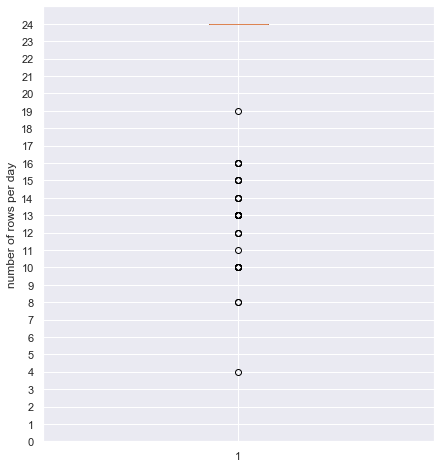

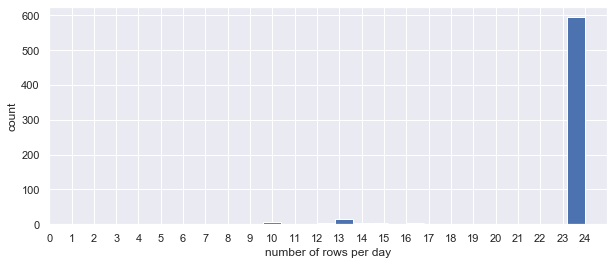

In [90]:
rows_per_day = data.groupby(data.index.date).apply(lambda x: len(x))

plt.figure(figsize=(7,8))
plt.boxplot(rows_per_day)
plt.ylabel('number of rows per day')
plt.yticks(np.arange(0,25,1))

plt.show()

plt.figure(figsize=(10,4))
plt.hist(rows_per_day, bins=25)
plt.xlabel('number of rows per day')
plt.ylabel('count')
plt.xticks(np.arange(0,25,1))
plt.show()

We can see that we have mostly 24 hours for all the days, only a very few outliers are present.

In [91]:
g_by_day = data.groupby(data.index.date)['temperature'].count()
s_missing = g_by_day[g_by_day !=24]
print(f'Total number days with missing rows: {len(s_missing)} out of {len(g_by_day)}, which is {100.0%len(s_missing)/len(g_by_day):.2f} %')

Total number days with missing rows: 42 out of 637, which is 0.03 %


There are only a few rows of data missing and we will not bother with that. One could look for nearby stations and impute the values from them, instead, we will take the median for the features at those hours and apply it there. This will be done in a later step, though

In [92]:
def add_missing_rows(df, s_missing):
    day = s_missing.index[ii].strftime("%Y-%m-%d")
    # pull this dataframe out of the dataframe for that missing day
    missing_day = df[day:day]
    # resample the index for the 24 hours (0 to 23 o clock)
    start = missing_day.index.date[0].strftime("%Y-%m-%d") + ' 00:00:00'
    end = missing_day.index.date[0].strftime("%Y-%m-%d") + ' 23:00:00'
    idx = pd.date_range(start, end, freq='H')
    # reindex
    missing_day = missing_day.reindex(idx, fill_value=np.nan)

    # delete the rows from the df
    rows_to_drop = df[ day ].index
    # Delete these row indexes from dataFrame
    df = df.drop(rows_to_drop)
    # return the new df
    df = pd.concat([df, missing_day], axis='rows')
    df.sort_index(inplace=True)
    
    return df
        
for ii in range(len(s_missing)):
     data = add_missing_rows(data, s_missing)

After these rows have been inserted, it is important to check that the number of days with a record in the dataframe equals the number of days that there are between the beginning and end of the period.

In [93]:
# check if it was effective
g_by_day = data.groupby(data.index.date).apply(lambda x: len(x))
# number of missing days
s_missing_after = g_by_day[g_by_day !=24]
print(f'Total number days with missing rows: {len(s_missing_after)} out of {len(g_by_day)}')
# how many days are there
idx = pd.date_range(g_by_day.index[0].strftime("%Y-%m-%d"), g_by_day.index[-1].strftime("%Y-%m-%d"), freq='D')
# assert that the number of days with a record in the dataframe equals the number of days that there are between the beginning and end of the period
assert len(idx) == len(g_by_day)

Total number days with missing rows: 0 out of 637


# Save to file

In [94]:
path_to_jsons = './data/DarkSkyAPI/'
data.to_csv(f'{path_to_jsons}/darkSkyData_cleaned_extracted.csv')